# Partitioned Circuit Extraction Walkthrough

Final phase of the circuit partioning framework is the extraction of a partitioned quanutm circuit. 

Using the QuantumCircuitHyperGraph object and a node assignment function, we can infer the required teleportation operations and build a quantum cirucit.
The qubits are split across multiple registers - one for each partition. Each partition is also initialised with a communication qubit register and a classical bit register for facilitating the teleportation. Additional communication qubits may be added if there are not enough available.

## Build initial circuit

First build/import and transpile the circuit. We use a fixed depth random circuit as an example.

In [1]:
from MLFM_GCP.circuits.cp_fraction import cp_fraction
from MLFM_GCP.circuits.QAOA import QAOA_random

from MLFM_GCP.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from MLFM_GCP.partitioning.FM.FM_methods import set_initial_partitions
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from MLFM_GCP.utils.qiskit_to_op_list import *

num_qubits = 32

circuit = cp_fraction(  num_qubits = num_qubits,
                        depth = num_qubits,
                        fraction= 0.5)

# circuit = QuantumVolume(num_qubits, 10)

# circuit = QAOA_random(num_qubits, prob=0.9, reps=1)

# circuit = QFT(num_qubits, do_swaps=False)

circuit = transpile(circuit, basis_gates=['cp', 'u'])

depth = circuit.depth()


if num_qubits < 12:
    circuit.draw(output='mpl', style='bw', fold=100)



## Graph building

We then build the graph using the QuantumCircuitHyperGraph object. We also define the paremeteres of the QPU architecture using the qpu_info and comm_info variables, which tell us how many physical qubits are in each partition.

We can draw the resulting graph using matplotlib. 

E-bit cost for unoptimised assignment:  155


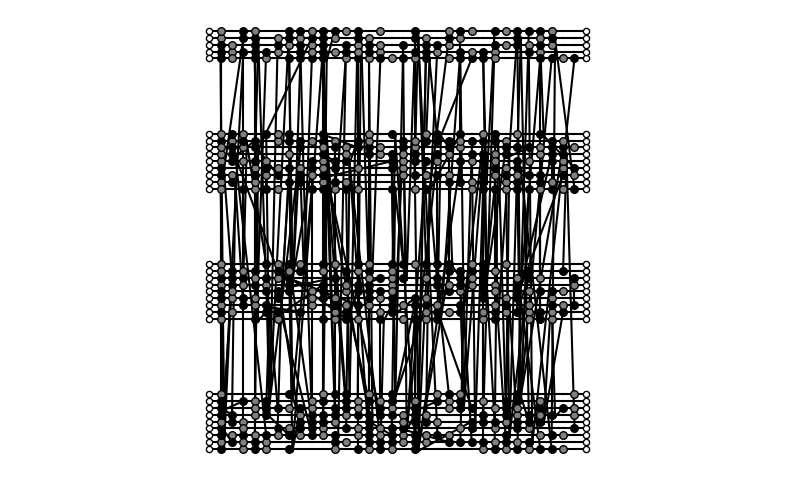

In [2]:
num_partitions = 4

qpu_size = int(num_qubits / num_partitions) + 1

qpu_info = [qpu_size] * num_partitions

comm_info = [2] * num_partitions

group_gates = True

graph = QuantumCircuitHyperGraph(circuit = circuit,
                                 group_gates = group_gates,
                                 anti_diag = False)

assignment = set_initial_partitions(qpu_info = qpu_info, 
                                    num_qubits = num_qubits, 
                                    num_layers = depth, 
                                    num_partitions = num_partitions, 
                                    reduced = True)

from MLFM_GCP.partitioning.FM.FM_methods import calculate_full_cost

cost = calculate_full_cost(graph, assignment, num_partitions)

print("E-bit cost for unoptimised assignment: ", cost)

from MLFM_GCP.drawing.tikz_drawing import *
from MLFM_GCP.drawing.mpl_drawing import *

mpl_fig = hypergraph_to_matplotlib(
    H=graph, 
    num_qubits=num_qubits,
    assignment=assignment,
    qpu_info=qpu_info,
    depth=depth
)

## Naive extraction

We can first set a baseline for the distributed circuit by extracting a partitioned circuit directly from the unoptimised assignment function. This will likely result in a very deep circuit which does not use entanglement efficiently.

First import the extractor class, passing in the graph and the partition assignment that we initialised before.

In [3]:
from MLFM_GCP.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                         partition_assignment=assignment, 
                                         qpu_info=qpu_info, 
                                         comm_info=comm_info)



basic_partitioned_circuit = extractor.extract_partitioned_circuit()

basic_partitioned_circuit_EPR = transpile(basic_partitioned_circuit, basis_gates=['cp','u','EPR'])

print(f"Depth of partitioned circuit: {basic_partitioned_circuit.depth()}")

EPR_count = basic_partitioned_circuit_EPR.count_ops()['EPR']
print(f"EPR count in partitioned circuit: {EPR_count}")



Depth of partitioned circuit: 309
EPR count in partitioned circuit: 155


We can draw the circuit to see where the teleportation blocks are occurring.

In [4]:
if num_qubits < 12:
    basic_partitioned_circuit_EPR.draw(output='mpl', style='bw', fold=100)
else:
    print("Number of qubits is 12 or more, skipping drawing.")

Number of qubits is 12 or more, skipping drawing.


To compare with original, we can transpile back into the U, CP gate-set, while choosing not to decompose the elementary entanglement generation options.

In [5]:
decomposed_circuit = transpile(basic_partitioned_circuit, basis_gates = ['cp', 'u', 'EPR'])

print(f"Depth of decomposed partitioned circuit: {decomposed_circuit.depth()}")

Depth of decomposed partitioned circuit: 793


We now optimise the node assignments using the recursive multilevel partitioning FM algorithm.

Initial cost: 155
All passes complete.
Final cost: 111
Best cost at level 0: 111
Initial cost: 111
All passes complete.
Final cost: 100
Best cost at level 1: 100
Initial cost: 100
All passes complete.
Final cost: 97
Best cost at level 2: 97
Initial cost: 97
All passes complete.
Final cost: 94
Best cost at level 3: 94
Initial cost: 94
All passes complete.
Final cost: 92
Best cost at level 4: 92
Initial cost: 92
All passes complete.
Final cost: 92
Best cost at level 5: 92


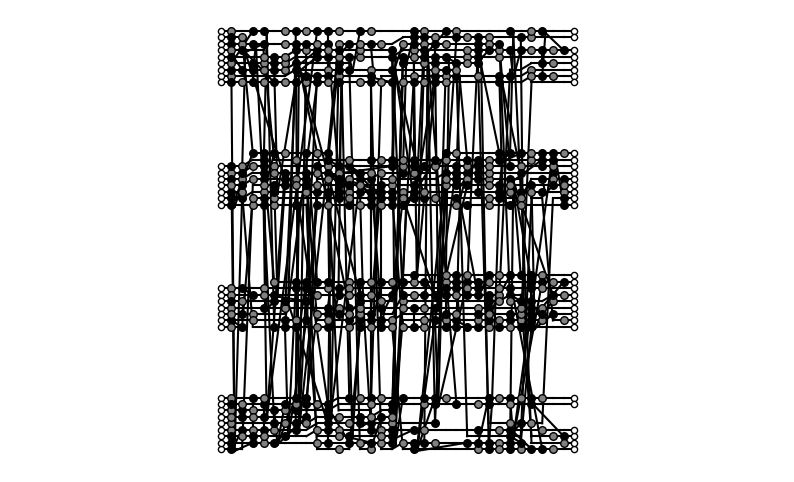

In [6]:
from MLFM_GCP.partitioning.FM.multilevel_FM import MLFM_recursive
import numpy as np

limit = 'qubit'

assignment_list, cost_list, time_list = MLFM_recursive(graph,
                                        assignment,  
                                        qpu_info, 
                                        limit = 'qubit', 
                                        pass_list = [50]*10, 
                                        stochastic = True, 
                                        lock_nodes = False,
                                        log = True,
                                        add_initial = False,
                                        costs = None)

optimised_assignment = assignment_list[np.argmin(cost_list)]

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    optimised_assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
)

Now define a new extractor for with the optimised assignment. 

In [7]:
extractor_opt = PartitionedCircuitExtractor(graph = graph, 
                                            partition_assignment = optimised_assignment, 
                                            qpu_info = qpu_info, 
                                            comm_info=comm_info)

partitioned_circuit_opt = extractor_opt.extract_partitioned_circuit()


print(f"Depth of optimised partitioned circuit: {partitioned_circuit_opt.depth()}")

partitioned_circuit_opt_EPR = transpile(partitioned_circuit_opt, basis_gates = ['cp', 'u', 'EPR'])

EPR_count_opt = partitioned_circuit_opt_EPR.count_ops()['EPR']

print(f"EPR count in optimised partitioned circuit: {EPR_count_opt}")



No linked communication qubits - check for relocated receivers
{10: (np.int64(1), 7), 15: (np.int64(3), 10)}


UnboundLocalError: cannot access local variable 'linked_root' where it is not associated with a value

In [ ]:
decomposed_circuit_opt = transpile(partitioned_circuit_opt, basis_gates = ['cp', 'u', 'EPR'])
print(f"Depth of decomposed partitioned circuit: {decomposed_circuit_opt.depth()}")

if num_qubits < 12:
    partitioned_circuit_opt.draw(output='mpl', style='bw', fold=100)
else:
    print("Number of qubits exceeds the limit for drawing.")

Depth of decomposed partitioned circuit: 140
Number of qubits exceeds the limit for drawing.


The depth of the resulting circuit should significantly lower than the unoptimised variant, though of course still much larger than the un-partitioned circuit. Some additional overhead is unavoidable.

## Validation

We would like to validate the output given by the partitioned circuit, which we can do using qiskits sampler class.

First we need to add measurements to the original, unpartitioned circuit.

In [ ]:
from qiskit import ClassicalRegister

creg = ClassicalRegister(num_qubits, name="c")
measured_circuit = circuit.copy()
measured_circuit.measure_all()


In [ ]:
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram


sampler = SamplerV2()

if num_qubits < 12:

    job = sampler.run([measured_circuit], shots=4096)
    job_result = job.result()
    data = job_result[0].data

    counts_base = data['meas'].get_counts()
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    plot_histogram(counts_base, bar_labels=False, ax=ax)
    ax.set_xticks([])


In [ ]:
if num_qubits < 12:

    part_circuit_dec = partitioned_circuit_opt.decompose().decompose().decompose()
    job = sampler.run([part_circuit_dec], shots=4096)
    job_result = job.result()
    data = job_result[0].data

    counts_part2 = data['result'].get_counts()

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    plot_histogram(data['result'].get_counts(),bar_labels=False,ax=ax)

    ax.set_xticks([])


The histograms look very similar, but we would like to verify the circuit statistically, which we can do using a distance measurement.

We take a distance measurement for two distributions from the base circuit and take a norm difference, then compare the distribution with

In [ ]:
def get_fidelity(counts1, counts2, shots):
    for key in counts1:
        digits = len(key)
        break
    norm = 0    
    max_string = '1'*digits
    integer = int(max_string, 2)
    for i in range(integer+1):
        binary = bin(i)
        binary = binary[2:]
        binary = '0'*(digits-len(binary)) + binary
        if binary in counts1:
            counts1_val = counts1[binary]/shots
        else:
            counts1_val = 0
        if binary in counts2:
            counts2_val = counts2[binary]/shots
        else:
            counts2_val = 0
        norm += np.abs(counts1_val - counts2_val)
    return norm**2


In [ ]:
if num_qubits < 12:

    shots = 9192

    job = sampler.run([measured_circuit], shots=shots)
    job_result = job.result()
    data = job_result[0].data

    counts_base1 = data['meas'].get_counts()

    job = sampler.run([measured_circuit], shots=shots)
    job_result = job.result()
    data = job_result[0].data

    counts_base2 = data['meas'].get_counts()

    fidelity_12 = get_fidelity(counts_base1, counts_base2, shots)

    print(f'Fidelity between outcomes from two runs of base: {fidelity_12}')

    job = sampler.run([part_circuit_dec], shots = shots)
    job_result = job.result()
    data = job_result[0].data

    counts_part2 = data['result'].get_counts()

    norm = get_fidelity(counts_base1, counts_part2, shots)
    fidelity = get_fidelity(counts_base1, counts_part2, shots)

    print(f'Fidelity between outcomes from base and partitioned circuit: {fidelity}')

In [ ]:
# decomposed_circuit_opt.draw(output='mpl', style='bw', fold=50)

In [ ]:
from qiskit import QuantumCircuit
from MLFM_GCP.utils.qiskit_to_op_list import circuit_to_gate_layers

def extract_entanglement_instructions(decomposed_circuit: QuantumCircuit) -> list:
    gate_layers = circuit_to_gate_layers(decomposed_circuit)
    entanglement_instructions = {'entanglement instructions' : []}
    for t, layer in enumerate(gate_layers):
        for gate in layer:

            if gate[0] == 'EPR':
                print(gate)
                entanglement_instructions['entanglement instructions'].append({'time step' : t, 'qubit indices' : gate[1:], 'qubit IDs' : gate[1]})
    
    return entanglement_instructions

entanglement_instructions = extract_entanglement_instructions(decomposed_circuit_opt)

for instruction in entanglement_instructions['entanglement instructions']:
    print(f"Time step: {instruction['time step']}, Qubit indices: {instruction['qubit indices']}, Qubit IDs: {instruction['qubit IDs']}")

['EPR', [20, 24], ['comm_0_0', 'comm_2_0'], []]
['EPR', [25, 22], ['comm_2_0', 'comm_1_0'], []]
['EPR', [23, 26], ['comm_1_0', 'comm_3_0'], []]
['EPR', [20, 25], ['comm_0_0', 'comm_2_0'], []]
['EPR', [20, 27], ['comm_0_0', 'comm_3_0'], []]
['EPR', [22, 21], ['comm_1_0', 'comm_0_0'], []]
['EPR', [28, 20], ['comm_3_1', 'comm_0_0'], []]
['EPR', [22, 25], ['comm_1_0', 'comm_2_0'], []]
['EPR', [28, 23], ['comm_3_1', 'comm_1_0'], []]
['EPR', [27, 24], ['comm_3_0', 'comm_2_0'], []]
['EPR', [29, 21], ['comm_1_1', 'comm_0_0'], []]
['EPR', [28, 22], ['comm_3_1', 'comm_1_0'], []]
['EPR', [25, 23], ['comm_2_0', 'comm_1_0'], []]
['EPR', [23, 20], ['comm_1_0', 'comm_0_0'], []]
['EPR', [25, 29], ['comm_2_0', 'comm_1_1'], []]
['EPR', [20, 25], ['comm_0_0', 'comm_2_0'], []]
['EPR', [29, 24], ['comm_1_1', 'comm_2_0'], []]
['EPR', [22, 25], ['comm_1_0', 'comm_2_0'], []]
['EPR', [25, 21], ['comm_2_0', 'comm_0_0'], []]
['EPR', [25, 20], ['comm_2_0', 'comm_0_0'], []]
['EPR', [25, 23], ['comm_2_0', 'comm_1_0

In [ ]:
gate_layers = circuit_to_gate_layers(decomposed_circuit_opt)
gate_layers = layer_list_to_dict(gate_layers)

for l, layer in gate_layers.items():
    print("Layer: ", l)
    for gate in layer:
        print(gate)

Layer:  0
{'type': 'single-qubit', 'name': 'u', 'qargs': [3], 'qregs': ['part0_data'], 'params': [1.377630756715059, 0.5324070144023647, 1.7417568046677054]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [5], 'qregs': ['part1_data'], 'params': [2.1176839346165726, 1.9564578191479853, 2.4916045876790385]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [6], 'qregs': ['part1_data'], 'params': [5.133514385341167, 3.990524299839479, 4.540893179108228]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [7], 'qregs': ['part1_data'], 'params': [1.8210605322289657, 5.477161147050105, 5.489706286655741]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [8], 'qregs': ['part1_data'], 'params': [2.4098601903993115, -3.089001004086472, 3.002095377537402]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [9], 'qregs': ['part1_data'], 'params': [5.331418149818092, 5.145021744883241, 3.3580117493856556]}
{'type': 'single-qubit', 'name': 'u', 'qargs': [10], 'qregs': ['part2_data'], 'params': [4.43341182093065

These numbers should both be very close to 0 and very similar to each other! If not then something has gone wrong in the circuit extraction.